Taken from __[Blinkity/metagame](https://github.com/Blinkity/metagame)__ adapted for Fantasy Strike matchups.

Given a matchup chart, this script can determine the play rate boundaries.

Thanks to FS Discord's
* @rogueyoshi for suggesting using a Jupyter notebook
* @ritielko for making the script work

In [1]:
# Install pip packages: matplotlib pandas seaborn numpy seaborn gspread
import sys
!{sys.executable} -m pip install matplotlib pandas numpy seaborn gspread

tensorboard 2.0.1 has requirement google-auth<2,>=1.6.3, but you'll have google-auth 2.2.1 which is incompatible.
tensorboard 2.0.1 has requirement setuptools>=41.0.0, but you'll have setuptools 40.2.0 which is incompatible.
google-auth 2.2.1 has requirement setuptools>=40.3.0, but you'll have setuptools 40.2.0 which is incompatible.
You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Import and alias pip modules
from pulp import *
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib as mp
import gspread as gs

sns.set(style="darkgrid")

Assuming a matchup chart like [this](matchup.md):

| Vs       | Grave | Jaina | Midori | Setsuki | Rook | DeGrey | Valerie | Geiger | Lum | Argagarg | Quince | Onimaru |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Grave    |   _   |     4 |    5.5 |       4 |    6 |    4.5 |       5 |    4.5 | 5.5 |      4.5 |    4.5 |       6 |
| Jaina    |     6 |   _   |      6 |     4.5 |  6.5 |    4.5 |       5 |      5 |   6 |      6.5 |    4.5 |     4.5 |
| Midori   |   4.5 |     4 |    _   |       5 |    6 |    4.5 |       4 |      4 |   4 |        4 |    4.5 |     6.5 |
| Setsuki  |   6.5 |   5.5 |      5 |    _    |  5.5 |      4 |     4.5 |      5 |   6 |        6 |    6.5 |       6 |
| Rook     |     4 |   3.5 |      4 |     4.5 |   _  |      4 |     5.5 |      3 |   3 |        3 |      5 |       5 |
| DeGrey   |   5.5 |   5.5 |    5.5 |       6 |    6 |    _   |     5.5 |    4.5 |   5 |        5 |      6 |     5.5 |
| Valerie  |     5 |     5 |      6 |     5.5 |  4.5 |    4.5 |    _    |      4 | 6.5 |        6 |    6.5 |       5 |
| Geiger   |   5.5 |     5 |      6 |       5 |    7 |    5.5 |       6 |    _   |   5 |        5 |      4 |       6 |
| Lum      |   4.5 |     4 |      6 |       4 |    7 |      5 |     3.5 |      5 |  _  |        4 |      5 |       5 |
| Argagarg |   5.5 |   3.5 |      6 |       4 |    7 |      5 |       4 |      5 |   6 |     _    |      5 |     2.5 |
| Quince   |   5.5 |   5.5 |    5.5 |     3.5 |    5 |      4 |     3.5 |      6 |   5 |        5 |    _   |       5 |
| Onimaru  |     4 |   5.5 |    3.5 |       4 |    5 |    4.5 |       5 |      4 |   5 |      7.7 |      5 |    _    |

* Underscores (_) are empty and just to make the markdown work
* Source is rogueyoshi's Season 9 chart

This script expects a CSV format like [so](matchups.csv):

```
Grave,0.5,0.4,0.55,0.4,0.6,0.45,0.5,0.45,0.55,0.45,0.45,0.6
Jaina,0.6,0.5,0.6,0.45,0.65,0.45,0.5,0.5,0.6,0.65,0.45,0.45
Midori,0.45,0.4,0.5,0.5,0.6,0.45,0.4,0.4,0.4,0.4,0.45,0.65
Setsuki,0.6,0.55,0.5,0.5,0.55,0.4,0.45,0.5,0.6,0.6,0.65,0.6
Rook,0.4,0.35,0.4,0.45,0.5,0.4,0.55,0.3,0.3,0.3,0.5,0.5
DeGrey,0.55,0.55,0.55,0.6,0.6,0.5,0.55,0.45,0.5,0.5,0.6,0.55
Valerie,0.5,0.5,0.6,0.55,0.45,0.45,0.5,0.4,0.65,0.6,0.65,0.5
Geiger,0.55,0.5,0.6,0.5,0.7,0.55,0.6,0.5,0.5,0.5,0.4,0.6
Lum,0.45,0.4,0.6,0.4,0.7,0.5,0.35,0.5,0.5,0.4,0.5,0.5
Argagarg,0.55,0.35,0.6,0.4,0.7,0.5,0.4,0.5,0.6,0.5,0.5,0.25
Quince,0.55,0.55,0.55,0.35,0.5,0.4,0.35,0.6,0.5,0.5,0.5,0.5
Onimaru,0.4,0.55,0.35,0.4,0.5,0.45,0.5,0.4,0.5,0.75,0.5,0.5
```

Notice the following:

* Headers are removed
* Blanks are replaced with 5
* Values must be between 0 to 1, so each value is divided by 10

Since matchup charts are typically Google spreadsheets, they can be exported as CSV via `File > Download > Comma-separated values` but make sure to remove unneccesary columns like `Totals`. 

Matchups Samples:
- __[Apothix](https://docs.google.com/spreadsheets/d/1kPmKxD0TAaLMu6RkAd62Zp1M2Mo92BxXpeDu0M_XDUU/edit#gid=1117169661)__
- __[rogueyoshi](https://docs.google.com/spreadsheets/d/16EW7UcgOb4F6Q_8XK3xjEzXp6Cf8bhLBg2vBMPSO_wg/edit#gid=1117169661)__



In [3]:
# Options:
# NUM_CHARACTERS: Number of characters in the matchup. Usually the number of rows.
# HEADER: If the file has a character name header. Usually if a Google Spreadsheet CSV
# FILENAME: Matchup filename to use

# Sample Fantasy Strike matchup data
NUM_CHARACTERS = 12 
HEADER = False
FILENAME = "matchups.csv"
# Rogueyoshi's Season 9 Fantasy Strike matchup data
# NUM_CHARACTERS = 12 
# HEADER = True
# FILENAME = "rogueyoshi_matchups_season_09.csv"
# Guilty Gear Strive GGAnalyser Celestial data
# NUM_CHARACTERS = 17
# HEADER = False
# FILENAME = "gganalyser-celestial.csv"

matchups = pd.read_csv(
    FILENAME, 
    header = (0 if HEADER else None),
    index_col = 0, 
    nrows = NUM_CHARACTERS, 
    usecols = range(0, NUM_CHARACTERS + 1)
)

def normalize_values(value):
    if np.isnan(value): # Empty values defaults to 5 or adjusted 0.5
        return 0.5
    elif value > 1:     # 1~10 values are adjusted to 0~1
        return value * 0.1
    else:
        return value
    
       
# Smoothen out values before calculating win rates
matchups = matchups.applymap(normalize_values)

matchups

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
Grave,0.50,0.40,0.55,0.40,0.60,0.45,0.50,0.45,0.55,0.45,0.45,0.60
Jaina,0.60,0.50,0.60,0.45,0.65,0.45,0.50,0.50,0.60,0.65,0.45,0.45
Midori,0.45,0.40,0.50,0.50,0.60,0.45,0.40,0.40,0.40,0.40,0.45,0.65
Setsuki,0.60,0.55,0.50,0.50,0.55,0.40,0.45,0.50,0.60,0.60,0.65,0.60
Rook,0.40,0.35,0.40,0.45,0.50,0.40,0.55,0.30,0.30,0.30,0.50,0.50
DeGrey,0.55,0.55,0.55,0.60,0.60,0.50,0.55,0.45,0.50,0.50,0.60,0.55
Valerie,0.50,0.50,0.60,0.55,0.45,0.45,0.50,0.40,0.65,0.60,0.65,0.50
Geiger,0.55,0.50,0.60,0.50,0.70,0.55,0.60,0.50,0.50,0.50,0.40,0.60
Lum,0.45,0.40,0.60,0.40,0.70,0.50,0.35,0.50,0.50,0.40,0.50,0.50


In [4]:
# Taken from bounds.py, calculate the converging play and win rates
def get_all_win_rates(matrix, division = 10):
    return pd.concat(
        [get_win_rates(row, matrix, division) for row in matrix.index.values], 
        axis=1
    )

def get_win_rates(rowname, matrix, division = 10):
    probs = np.linspace(0, 1, division + 1)
    return pd.Series(
        [solve_game_with_row_constraints(matrix, rowname, p)[1] for p in probs], 
        index = probs, 
        name = rowname
    )

def solve_game_with_row_constraints(matrix, rowname, constraint):
    prob, lp_vars = setup_basic_problem(matrix)
    prob += lpSum(lp_vars[rowname]) == constraint
    prob.solve(PULP_CBC_CMD(msg=False))
    game_val = value(lp_vars['w'])
    strat_probs = {}

    for row_strat in matrix.index.values:
        strat_probs[row_strat] = value(lp_vars[row_strat])

    return prob, game_val, strat_probs

def setup_basic_problem(matrix):
    prob = LpProblem("rock_paper_scissors", LpMaximize)
    the_vars = np.append(matrix.index.values, (["w"]))
    lp_vars = LpVariable.dicts("vrs", the_vars)
    prob += lpSum([lp_vars['w']])

    for row_strat in matrix.index.values:
        prob += lpSum([1.0 * lp_vars[row_strat]]) >= 0

    prob += lpSum([1.0 * lp_vars[x] for x in matrix.index.values]) == 1

    for col_strat in matrix.columns.values:
        stratTerms = [matrix.loc[row_strat, col_strat] * lp_vars[row_strat] for row_strat in matrix.index.values]
        allTerms = stratTerms + [-1 * lp_vars['w']]
        prob += lpSum(allTerms) >= 0

    return prob, lp_vars

# Horizontal division of the image
DIVISION = 10 # 0.1, 0.2, 0.3, ..., 1.0

matchup_payoffs = 2 * matchups - 1
all_win_rates = get_all_win_rates(matchup_payoffs, DIVISION)

all_win_rates

,Grave,Jaina,Midori,Setsuki,Rook,DeGrey,Valerie,Geiger,Lum,Argagarg,Quince,Onimaru
0.0,0.000000,0.000,0.000000,0.000,0.000000,-0.008889,0.000000,-0.031250,0.000000,0.000000,-0.006061,0.000000
0.1,-0.010000,-0.006,-0.014545,-0.002,-0.025455,-0.005273,-0.006000,-0.021250,-0.002424,-0.000667,-0.002727,-0.013333
0.2,-0.021333,-0.012,-0.029091,-0.004,-0.054545,-0.003273,-0.013333,-0.011250,-0.010909,-0.008333,0.000000,-0.033333
0.3,-0.035333,-0.018,-0.043636,-0.006,-0.086154,-0.001273,-0.023333,-0.004118,-0.022121,-0.036667,-0.023333,-0.053333
0.4,-0.049333,-0.024,-0.059429,-0.020,-0.120000,0.000000,-0.040000,0.000000,-0.043636,-0.080000,-0.053333,-0.073333
0.5,-0.063333,-0.030,-0.080000,-0.050,-0.155000,-0.010000,-0.060000,-0.003333,-0.077273,-0.139286,-0.083333,-0.094444
0.6,-0.080000,-0.044,-0.104000,-0.080,-0.200000,-0.020000,-0.080000,-0.006667,-0.110909,-0.200000,-0.126667,-0.117778
0.7,-0.110000,-0.058,-0.128000,-0.110,-0.250000,-0.030000,-0.100000,-0.050000,-0.150000,-0.262500,-0.170000,-0.150000
0.8,-0.140000,-0.072,-0.152000,-0.140,-0.300000,-0.040000,-0.120000,-0.100000,-0.200000,-0.340000,-0.213333,-0.200000
0.9,-0.170000,-0.086,-0.176000,-0.170,-0.350000,-0.070000,-0.160000,-0.150000,-0.250000,-0.420000,-0.256667,-0.250000


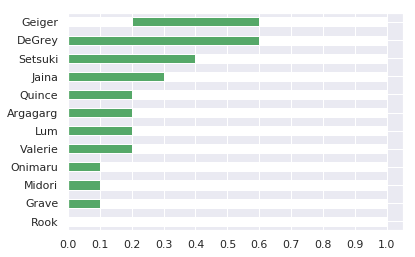

In [5]:
# Plot the win rates
def determine_intervals(win_rates, threshold):
        return win_rates.apply(lambda x: pd.Series([x[x >= threshold].first_valid_index(), x[x >= threshold].last_valid_index()], index = ['minv','maxv'])).T
    
def plot_intervals(intervals, do_sort):
    intervals['bar1'] = intervals['minv']
    intervals['bar2'] = intervals['maxv'] - intervals['minv']
    intervals['bar3'] = 1 - (intervals['bar1'] + intervals['bar2'])
 
    if do_sort:
        intervals = intervals.sort_values(by=['maxv','minv'])
    else:
        intervals = intervals.reindex(index=intervals.index[::-1])
    img = intervals[['bar1','bar2','bar3']].plot(kind='barh',stacked=True, color=['w','g','w'], xticks = np.linspace(0,1,11), legend=False)
    
    return img

intervals = determine_intervals(all_win_rates, -0.02)
img = plot_intervals(intervals, True)

img.get_figure().savefig(FILENAME.split('.')[0] + ".png")
